In [19]:
import sys

In [20]:
sys.path.append("/remote-home/songtianwei/research/unlearn_multimodal")
sys.path.append("/remote-home/songtianwei/research/unlearn_multimodal/data")

In [21]:
from dataset import create_dataset, create_sampler, create_loader

In [22]:
import argparse
import os
import ruamel.yaml as yaml
import numpy as np
import random
import time
import datetime
import json
import logging
from pathlib import Path

import clip

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

import utils
from dataset import create_dataset, create_sampler, create_loader
from scheduler import create_scheduler
from optim import create_optimizer

In [23]:
config = yaml.load(open("/remote-home/songtianwei/research/unlearn_multimodal/configs/Flickr_poison.yaml", 'r'), Loader=yaml.Loader)

In [24]:
config = {**config['common'], **config['step3']}

In [25]:
config['train_file']

['/remote-home/songtianwei/research/unlearn_multimodal/data/flickr30k_train.json']

In [26]:
train_dataset, val_dataset, test_dataset = create_dataset('re_train_poison', config)

In [27]:
for data in train_dataset:
    print(data)
    break

(tensor([[[0.0118, 0.0157, 0.0196,  ..., 0.7529, 0.8941, 0.8706],
         [0.0118, 0.0235, 0.0157,  ..., 0.7490, 0.5765, 0.7490],
         [0.0235, 0.0157, 0.0196,  ..., 0.2157, 0.2353, 0.4078],
         ...,
         [0.2980, 0.4000, 0.3725,  ..., 0.5333, 0.5647, 0.5294],
         [0.4196, 0.5647, 0.5451,  ..., 0.5843, 0.5216, 0.5686],
         [0.6902, 0.6196, 0.4824,  ..., 0.5922, 0.6118, 0.5529]],

        [[0.0235, 0.0196, 0.0235,  ..., 0.8863, 0.9922, 0.9882],
         [0.0118, 0.0235, 0.0235,  ..., 0.8941, 0.7529, 0.9176],
         [0.0392, 0.0196, 0.0196,  ..., 0.4275, 0.4549, 0.6549],
         ...,
         [0.4078, 0.4314, 0.3961,  ..., 0.7098, 0.7059, 0.6824],
         [0.5098, 0.6510, 0.6706,  ..., 0.7255, 0.6549, 0.7176],
         [0.7569, 0.7373, 0.7020,  ..., 0.6902, 0.7333, 0.6706]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.9294, 1.0000, 1.0000],
         [0.0118, 0.0235, 0.0196,  ..., 0.8235, 0.6902, 0.8745],
         [0.0275, 0.0157, 0.0196,  ..., 0.1059, 0.1098, 0

In [28]:
def show_one(tensor):

    import matplotlib.pyplot as plt
    import torch

    if tensor.requires_grad:
        tensor = tensor.detach()
    image = tensor.permute(1, 2, 0).cpu().numpy()  # 将通道维度移动到最后
    # print(image.shape)
    plt.imshow(image)
    plt.show()

In [29]:
def show(tensor):

    import matplotlib.pyplot as plt
    import torch

    if tensor.requires_grad:
        tensor = tensor.detach()

    # 可视化张量中的图像
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(16):
        row, col = i // 4, i % 4
        image = tensor[i].permute(1, 2, 0).cpu().numpy()  # 将通道维度移动到最后
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
    
    plt.show()

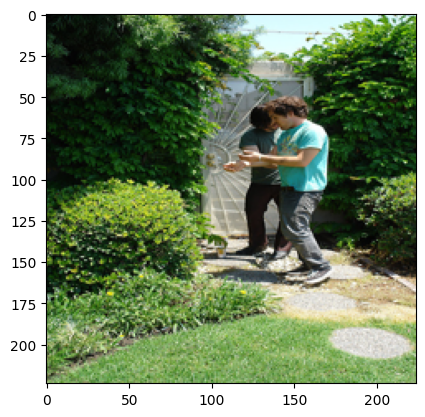

In [30]:
show_one(data[0])

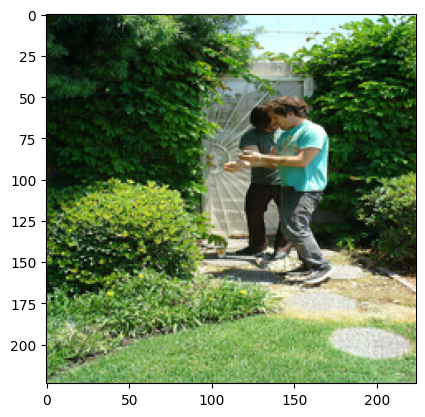

In [31]:
show_one(data[1])

In [34]:
delta = data[1] - data[0]

In [35]:
delta

tensor([[[ 0.0622,  0.0377,  0.0315,  ..., -0.0267, -0.0070,  0.0431],
         [ 0.0692,  0.0569,  0.0538,  ..., -0.0278, -0.0400,  0.0588],
         [ 0.0701,  0.0540,  0.0485,  ...,  0.0105, -0.0390,  0.0626],
         ...,
         [ 0.0206,  0.0033,  0.0068,  ...,  0.0377, -0.0108,  0.0640],
         [ 0.0215,  0.0132,  0.0114,  ..., -0.0012, -0.0288,  0.0604],
         [ 0.0241,  0.0256,  0.0249,  ...,  0.0406,  0.0027,  0.0609]],

        [[ 0.0622,  0.0559,  0.0533,  ..., -0.0071,  0.0036,  0.0118],
         [ 0.0681,  0.0642,  0.0613,  ..., -0.0312, -0.0400,  0.0717],
         [ 0.0698,  0.0687,  0.0683,  ...,  0.0174, -0.0266,  0.0719],
         ...,
         [ 0.0429,  0.0436,  0.0348,  ..., -0.0281, -0.0456,  0.0690],
         [ 0.0436,  0.0456,  0.0379,  ..., -0.0235, -0.0351,  0.0682],
         [ 0.0442,  0.0511,  0.0477,  ...,  0.0398,  0.0129,  0.0694]],

        [[ 0.0528, -0.0038, -0.0196,  ..., -0.0593, -0.0477,  0.0000],
         [ 0.0666,  0.0256, -0.0077,  ..., -0

In [36]:
delta.shape

torch.Size([3, 224, 224])

In [37]:
data[1]

tensor([[[0.0740, 0.0534, 0.0511,  ..., 0.7262, 0.8872, 0.9137],
         [0.0810, 0.0805, 0.0695,  ..., 0.7212, 0.5364, 0.8078],
         [0.0937, 0.0697, 0.0681,  ..., 0.2262, 0.1963, 0.4704],
         ...,
         [0.3186, 0.4033, 0.3793,  ..., 0.5711, 0.5539, 0.5934],
         [0.4411, 0.5779, 0.5565,  ..., 0.5831, 0.4928, 0.6290],
         [0.7143, 0.6453, 0.5073,  ..., 0.6328, 0.6144, 0.6139]],

        [[0.0857, 0.0755, 0.0769,  ..., 0.8792, 0.9958, 1.0000],
         [0.0799, 0.0877, 0.0848,  ..., 0.8629, 0.7130, 0.9893],
         [0.1090, 0.0883, 0.0879,  ..., 0.4449, 0.4283, 0.7268],
         ...,
         [0.4508, 0.4749, 0.4308,  ..., 0.6817, 0.6603, 0.7513],
         [0.5534, 0.6966, 0.7085,  ..., 0.7020, 0.6198, 0.7858],
         [0.8010, 0.7884, 0.7496,  ..., 0.7300, 0.7463, 0.7400]],

        [[0.0724, 0.0158, 0.0000,  ..., 0.8701, 0.9523, 1.0000],
         [0.0784, 0.0491, 0.0119,  ..., 0.7732, 0.6554, 0.8811],
         [0.0960, 0.0404, 0.0083,  ..., 0.0880, 0.0619, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


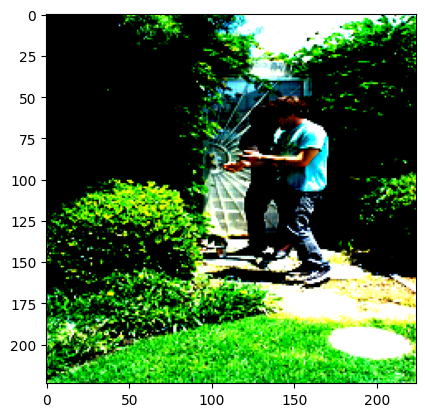

In [38]:
show_one(data[2])

In [41]:
! pwd

/remote-home/songtianwei/research/unlearn_multimodal/debug


In [45]:
image_ori = torch.load("../image_ori.pt")

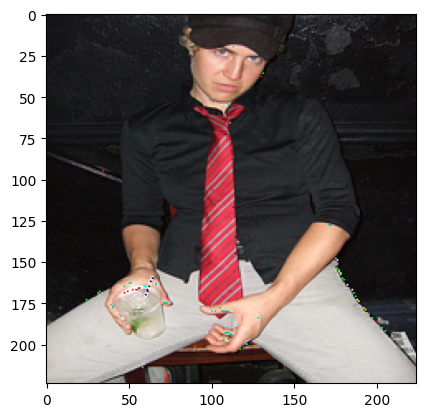

In [46]:
show_one(image_ori)

In [47]:
image_adv = torch.load("../image_adv.pt")

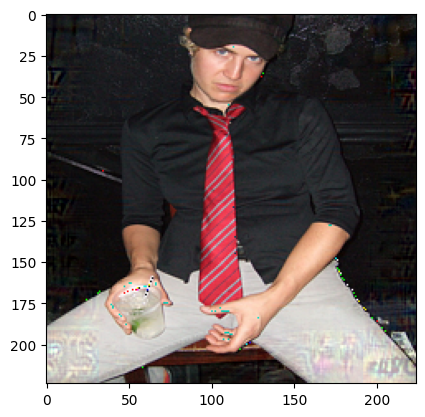

In [48]:
show_one(image_adv)

In [44]:
caption = 'a man wearing a necktie sitting down and trying to take a drink'

In [50]:
import clip

In [54]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [56]:
model = model.to(device)

In [100]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("../CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", caption]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[9.956e-01 4.265e-03 9.274e-05]]


In [102]:
image = image_ori.unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", 'a woman', 'a man wearing a necktie sitting down and trying to take a drink']).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.006992 0.002533 0.99    ]]


In [92]:
cos(image_features[0],text_features)

tensor([0.1857, 0.2175, 0.2354], device='cuda:0', dtype=torch.float16)

image_adv

In [103]:
image = image_adv.unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", 'a woman', 'a man wearing a necktie sitting down and trying to take a drink']).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.341  0.0876 0.5713]]


In [94]:
image_features.shape

torch.Size([1, 512])

In [95]:
cos(image_features[0],text_features)

tensor([0.2078], device='cuda:0', dtype=torch.float16)

In [96]:
image = torch.rand_like(image_adv).unsqueeze(0).to(device)
text = clip.tokenize([ 'a man wearing a necktie sitting down and trying to take a drink']).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[1.]]


In [97]:
cos(image_features,text_features)

tensor([0.1841], device='cuda:0', dtype=torch.float16)

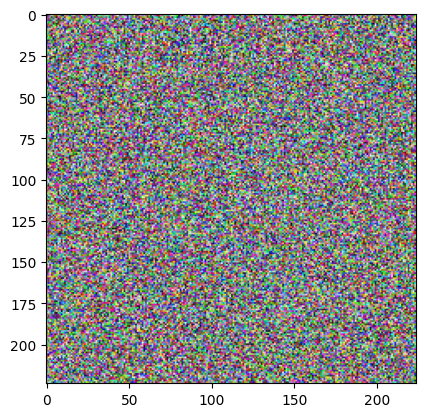

In [72]:
show_one(image[0])